# EC771 - Empirical Assignment: Regression Discontinuity
## Michaela Philip

### Assignment by Professor Ian McCarthy

### All data from Keith M. Marzilli Ericson (2014)

In [1]:
# import numpy as np 
import pandas as pd 
# from tabulate import tabulate 
# import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
# from rdrobust import rdrobust,rdbwselect,rdplot

warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

TODO fix general formatting :(
    
    tables showing up twice?
    
    () around se

##### 1. Recreate the table of descriptive statistics (Table 1) from Ericson (2014).

In [2]:
from analysis.q1 import table_1 as table_1
table_1

,2006,2007,2008,2009,2010
Mean monthly premium,$37,$40,$36,$30,$33
,(13),(17),(20),(5),(9)
Mean deductible,$92,$114,$146,$253,$118
,(116),(128),(125),(102),(139)
Fraction enhanced benefit,0.43,0.43,0.58,0.03,0.69
Fraction of US firms,0.0,0.76,0.98,1.0,0.97
Fraction of state firms,0.0,0.53,0.91,0.68,0.86
Number of unique firms,51,38,16,5,6
Number of plans,"1,429",658,202,68,107


##### 2. Recreate Figure 3 from Ericson (2014).

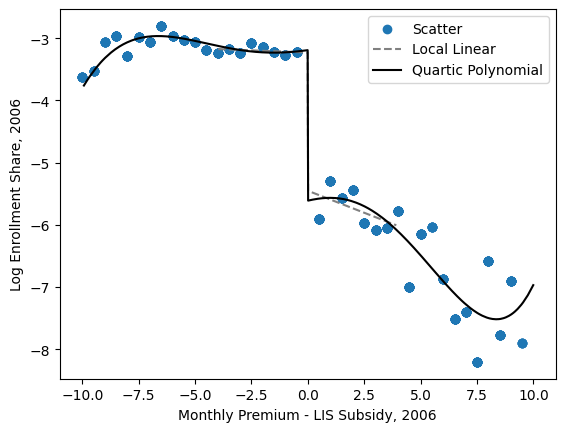

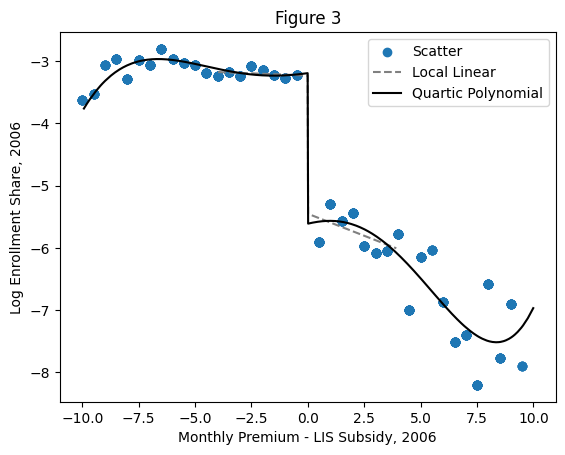

In [3]:
from analysis.q2 import scatter_data, lin_data_sort, poly_data_sort
ytitle = "Log Enrollment Share, 2006"
plt.scatter(scatter_data['bin'], scatter_data['bin_scatter'], label='Scatter')
plt.plot(lin_data_sort['lis_premium'], lin_data_sort['local_lin'], linestyle='dashed', color='gray', label='Local Linear')
plt.plot(poly_data_sort['lis_premium'], poly_data_sort['quart_poly'], linestyle='solid', color='black', label='Quartic Polynomial')
plt.xlabel("Monthly Premium - LIS Subsidy, 2006")
plt.ylabel(ytitle)
plt.title("Figure 3")
plt.legend()
plt.savefig('data/output/Figure3.png')

##### 3. Calonico, Cattaneo, and Titiunik (2015) discuss the appropriate partition size for binned scatterplots such as that in Figure 3 of Ericson (2014). More formally, denote by $\mathbb{P}_{-,n} = \{P_{-,j} : j = 1, 2, ...J_{-,n}\}$ and $\mathbb{P_{+,n}} = \{P_{+,j} : j = 1, 2, ...J_{+,n}\}$ the partitions of the support of the running variable $x_i$ on the left and right (respectively) of the cutoff, $\bar{x}$. $P_{-,j}$ and $P_{+,n}$ denote the actual supports for each $j$ partition of size $J_{-,n}$ and $J_{+,n}$ such that $[x_l, \bar{x}) = \cup_{j=1}^{J_{-.n}} P_{-,j}$ and $(\bar{x}, x_u] = \cup_{j=1}^{J_{+,n}} P_{+,j}$. Individual bins are denoted by $p_{-,j}$ and $p_{+,j}$. With this notation in hand, we can write the partitions $J_{-,n}$ and $J_{+,n}$ with equally-spaced bins as $$ p_{-,j} = x_l + j \times \frac{\bar{x}-x_l}{J_{-,n}}$$ and $$p_{+,j} = \bar{x} + j \times \frac{x_u - \bar{x}}{J_{+,n}}$$ Recreate Figure 3 from Ericson (2014) using $J_{-,n} = J_{+,n} = 10$ and $J_{-,n} = J_{+,n} = 30$ Discuss your results and compare them to your figure in Part 2. 

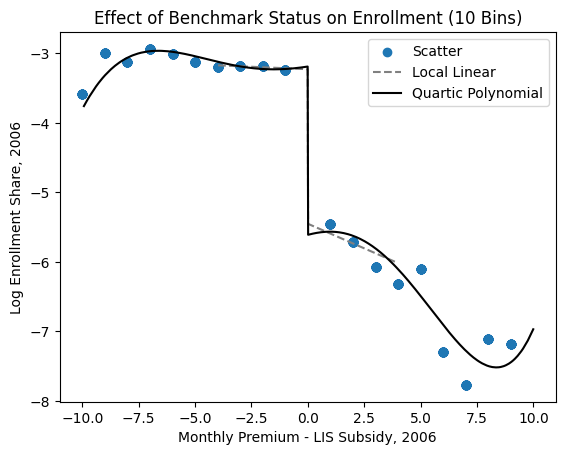

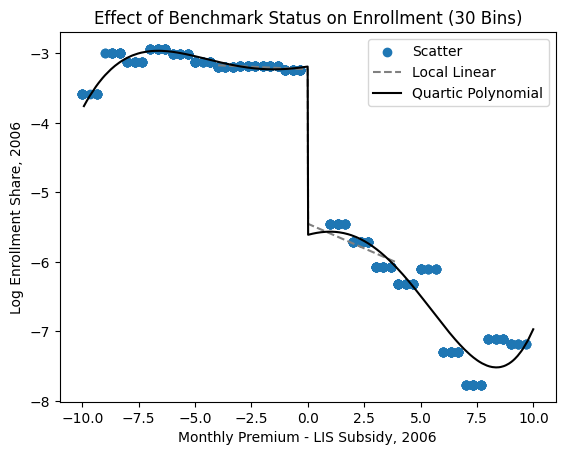

In [4]:
from analysis.q3 import scatter_data, lin_data_sort, poly_data_sort

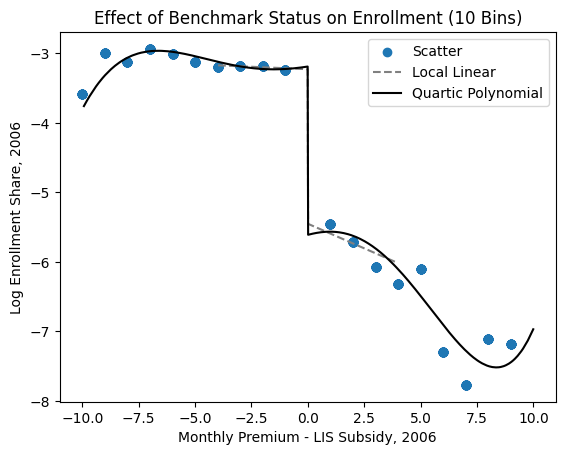

In [5]:
#creating the graph 
plt.close()
ytitle = "Log Enrollment Share, 2006"
plt.scatter(scatter_data['bin'], scatter_data['bin_scatter'], label='Scatter')
plt.plot(lin_data_sort['lis_premium'], lin_data_sort['local_lin'], linestyle='dashed', color='gray', label='Local Linear')
plt.plot(poly_data_sort['lis_premium'], poly_data_sort['quart_poly'], linestyle='solid', color='black', label='Quartic Polynomial')
plt.xlabel("Monthly Premium - LIS Subsidy, 2006")
plt.ylabel(ytitle)
plt.title("Effect of Benchmark Status on Enrollment (10 Bins)")
plt.legend()
# plt.savefig('data/output/Figure3a.png')

In [6]:
from analysis.q3 import scatter_data_2

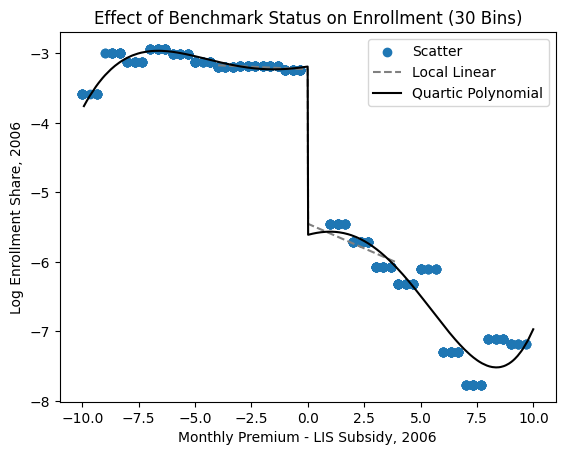

In [7]:
#creating the graph 
plt.close()
ytitle = "Log Enrollment Share, 2006"
plt.scatter(scatter_data_2['bin'], scatter_data_2['bin_scatter'], label='Scatter')
plt.plot(lin_data_sort['lis_premium'], lin_data_sort['local_lin'], linestyle='dashed', color='gray', label='Local Linear')
plt.plot(poly_data_sort['lis_premium'], poly_data_sort['quart_poly'], linestyle='solid', color='black', label='Quartic Polynomial')
plt.xlabel("Monthly Premium - LIS Subsidy, 2006")
plt.ylabel(ytitle)
plt.title("Effect of Benchmark Status on Enrollment (30 Bins)")
plt.legend()
# plt.savefig('data/output/Figure3b.png')

##### 4. With the notation above, Calonico, Cattaneo, and Titiunik (2015) derive the optimal number of partitions for an evenly-spaced (ES) RD plot. They show that $$J_{ES, -, n} = [\frac{V_-}{\mathbb{V}_{ES,-}} \frac{n}{\log(n)^2}]$$ and $$J_{ES, +, n} = [\frac{V_+}{\mathbb{V}_{ES,+}} \frac{n}{\log(n)^2}]$$ where $V_-$ and $V_+$ denote the sample variance of the subsamples to the left and right of the cutoff and $\Nu_{ES}$ is an integrated variance term derived in the paper. Use the rdrobust package in R (or Stata or Python) to find the optimal number of bins with an evenly-spaced binning strategy. Report this bin count and recreate your binned scatterplots from parts 2 and 3 based on the optimal bin number.

c:\Users\micha\Lib\site-packages\rdrobust\rdplot.py:743: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


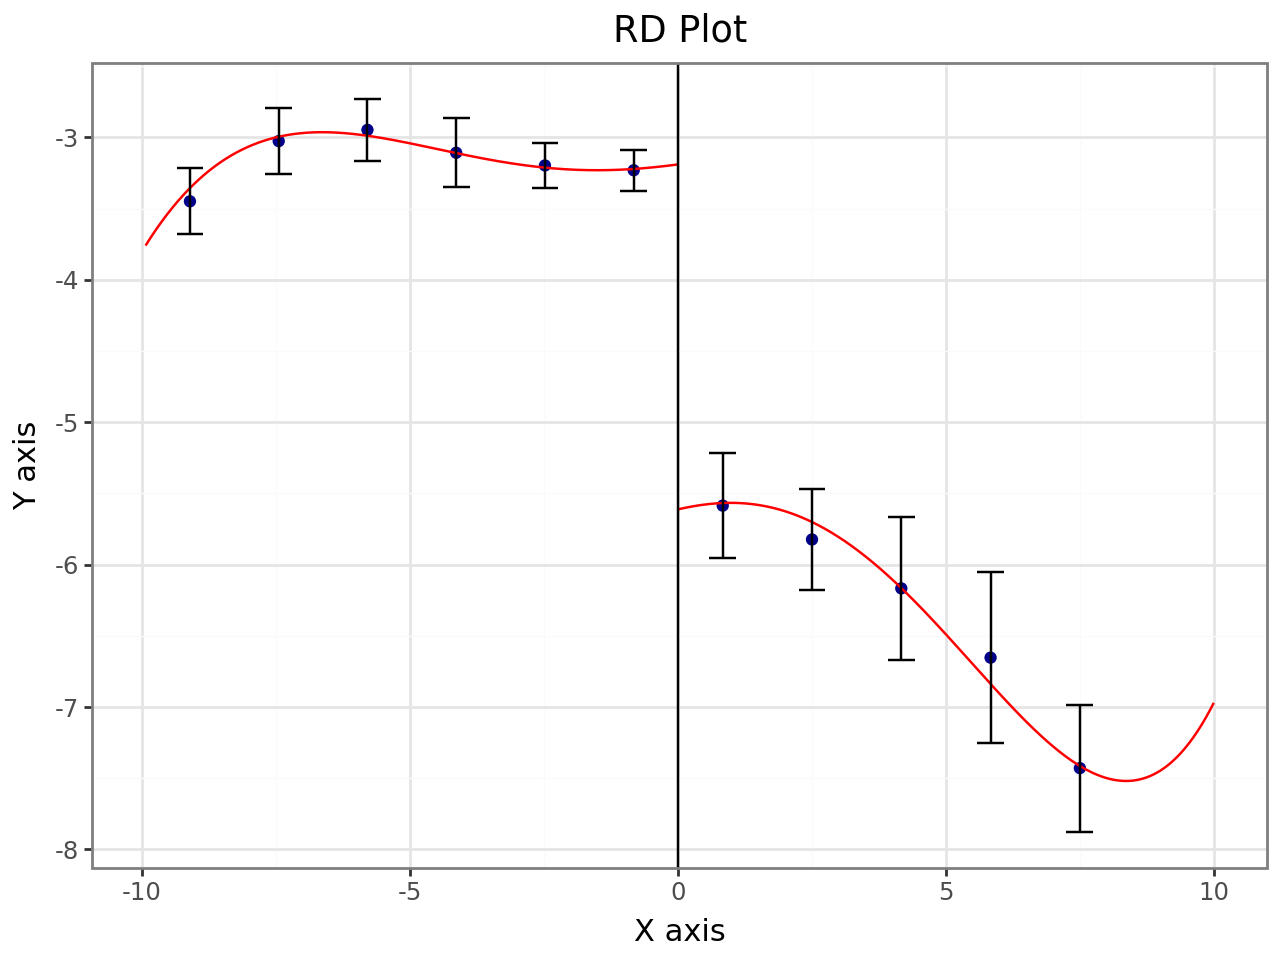

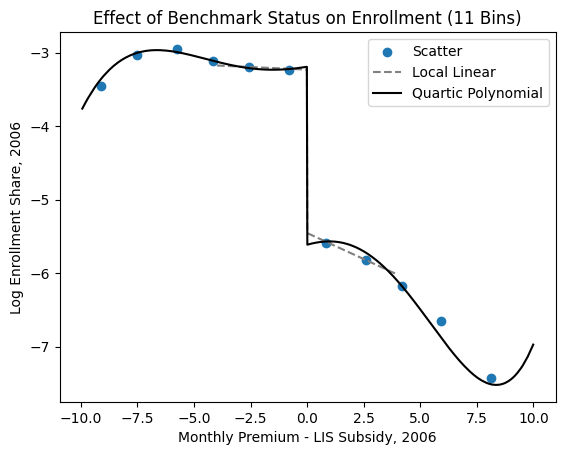

The optimal number of bins is 11.


In [8]:
from analysis.q4 import bin_scatter
x = bin_scatter.vars_bins.rdplot_mean_x
y= bin_scatter.vars_bins.rdplot_mean_y
n_bins = len(x)

The optimal number of bins is 11.


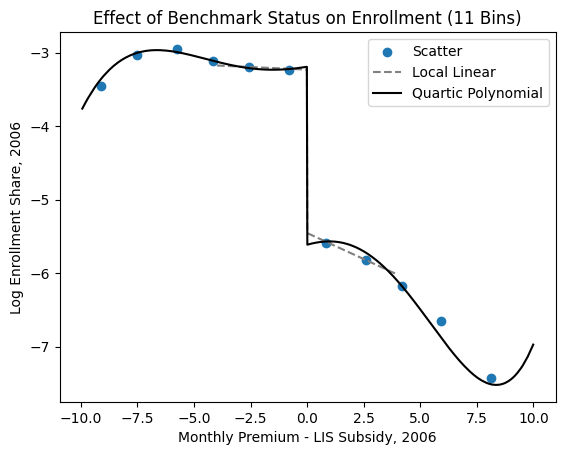

In [9]:
#creating the graph 
plt.close()
ytitle = "Log Enrollment Share, 2006"
plt.scatter(x, y, label='Scatter')
plt.plot(lin_data_sort['lis_premium'], lin_data_sort['local_lin'], linestyle='dashed', color='gray', label='Local Linear')
plt.plot(poly_data_sort['lis_premium'], poly_data_sort['quart_poly'], linestyle='solid', color='black', label='Quartic Polynomial')
plt.xlabel("Monthly Premium - LIS Subsidy, 2006")
plt.ylabel(ytitle)
plt.title("Effect of Benchmark Status on Enrollment (11 Bins)")
plt.legend()
# plt.savefig('data/output/Figure3d.png')
print("The optimal number of bins is " + str(n_bins) + ".")

##### 5. One key underlying assumption for RD design is that agents cannot precisely manipulate the running variable. While “precisely” is not very scientific, we can at least test for whether there appears to be a discrete jump in the running variable around the threshold. Evidence of such a jump may suggest that manipulation is present. Provide the results from the manipulation tests described in Cattaneo, Jansson, and Ma (2018). This test can be implemented with the rddensity package in R, Stata, or Python.

The p-value for the manipulation test is 2
The difference in estimated density at the cutoff is 0.0026


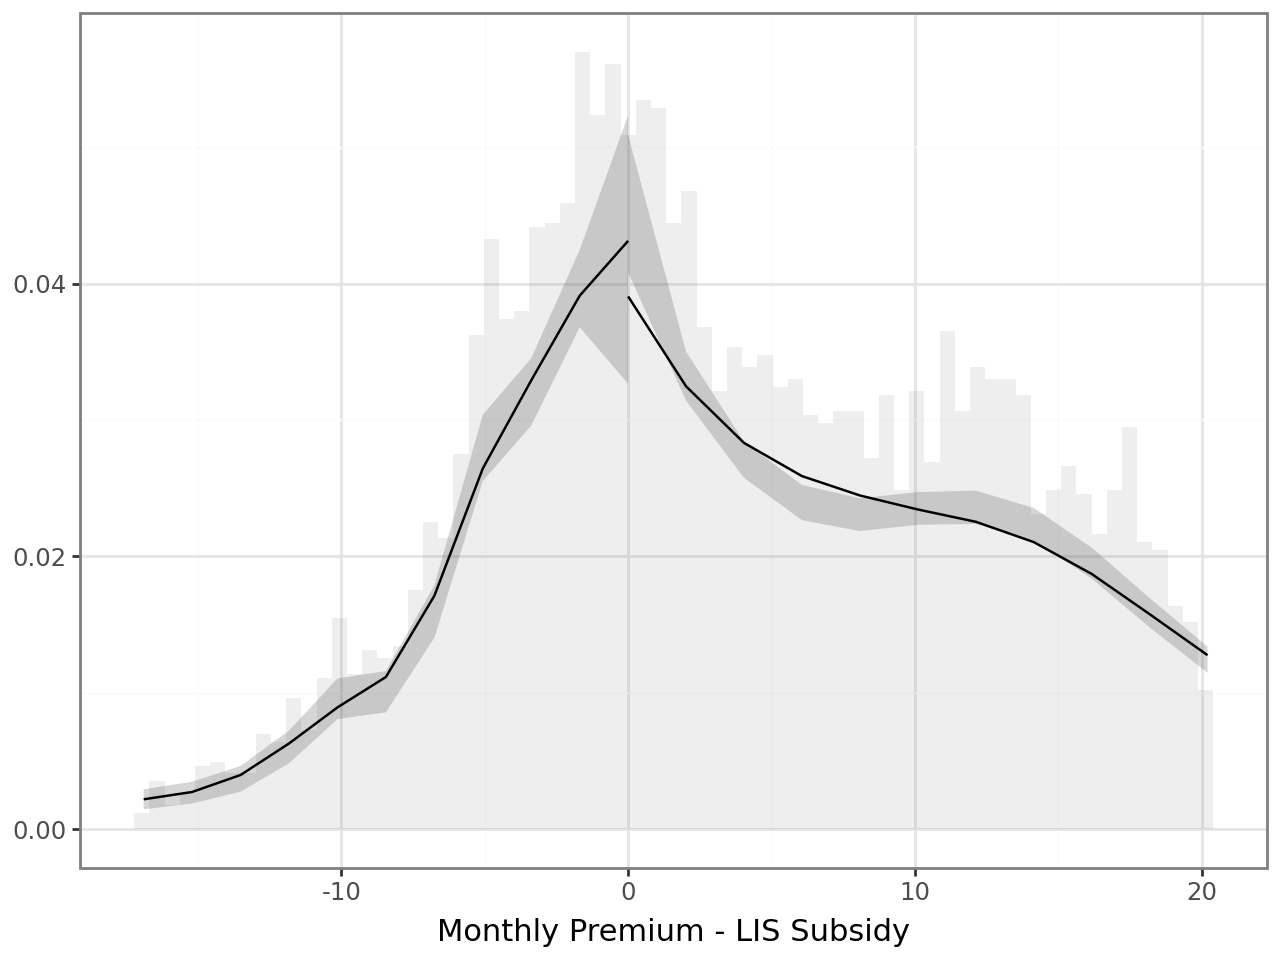

In [10]:
from analysis.q5 import rd_test_pval, rd_test_diff, density_plot

The p-value for the manipulation test is 2
The difference in estimated density at the cutoff is 0.0026


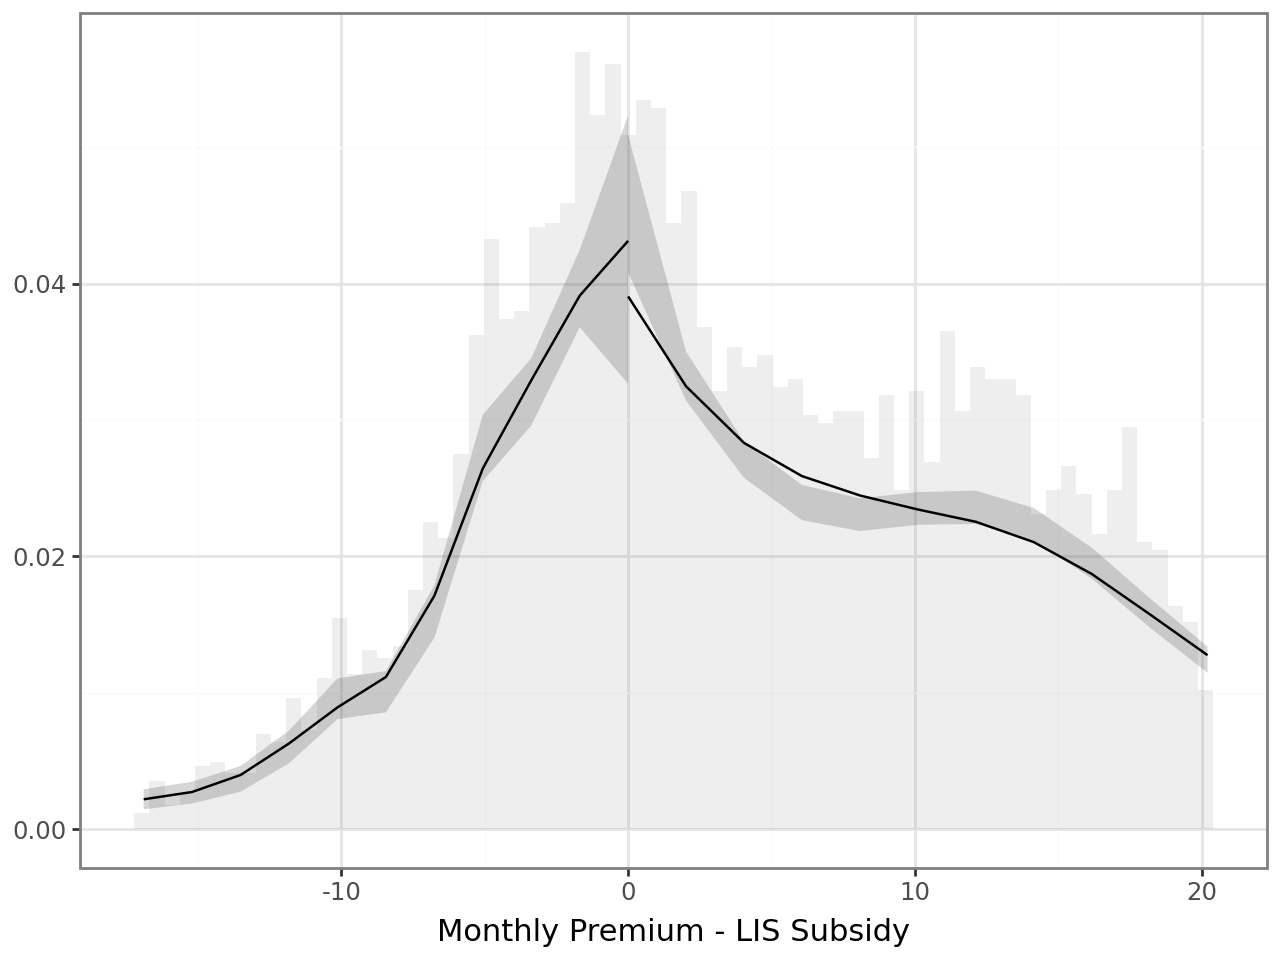

In [11]:
print("The p-value for the manipulation test is " + str(rd_test_pval))
print("The difference in estimated density at the cutoff is " + str((rd_test_diff.right - rd_test_diff.left).round(4)))
density_plot

##### 6. Recreate Panels A and B of Table 3 in Ericson (2014) using the same bandwidth of $4.00 but without any covariates.

In [12]:
from analysis.q6 import table_3 as table_3
table_3

,2006,2007,2008,2009,2010
"Panel A. Local linear, bandwidth $4",,,,,
"Below benchmark, 2006",2.224,0.0,0.0,0.0,0.0
,0.255,0.0,0.0,0.0,0.0
Below Benchmark,-0.014,-0.008,-0.014,-0.256,-0.103
,0.051,0.037,0.022,0.061,0.044
Above Benchmark,-0.142,-0.136,-0.076,-0.055,-0.078
,0.114,0.026,0.014,0.018,0.016
Observations,306.0,276.0,231.0,173.0,160.0
R^2,0.576,0.112,0.143,0.242,0.332
"Panel B. Polynomial, bandwidth $4",,,,,


##### 7. Calonico, Cattaneo, and Farrell (2020) show that pre-existing optimal bandwidth calculations (such as those used in Ericson (2014)) are invalid for appropriate inference. They propose an alternative method to derive minimal coverage error (CE)-optimal bandwidths. Re-estimate your RD results using the CE-optimal bandwidth (rdrobust will do this for you) and compare the bandwidth and RD estimates to that in Table 3 of Ericson (2014).

In [13]:
from analysis.q7 import table_4
table_4

,2006,2007,2008,2009,2010
"Panel A. Local linear, CE-optimal Bandwidths",,,,,
"LIS Premium, 2006",-2.091,-1.142,-0.608,-0.321,-0.241
,0.29,0.271,0.258,0.303,0.353
Bandwidth,3.44,3.69,4.4,3.78,4.26
"Panel B. Polynomial, CE-optimal Bandwidths",,,,,
"LIS Premium, 2006",-2.409,-1.306,-0.634,-0.276,-0.219
,0.361,0.346,0.317,0.342,0.384
Bandwidth,4.29,4.74,6.2,6.4,7.83


##### 8. Now let’s extend the analysis in Section V of Ericson (2014) using IV. Use the presence of Part D low-income subsidy as an IV for market share to examine the effect of market share in 2006 on future premium changes.

In [3]:
from analysis.q8 import iv
iv.summary

c:\Users\micha\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:           premium_diff   R-squared:                     -0.1232
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1234
No. Observations:                5446   F-statistic:                    278.56
Date:                Fri, Apr 19 2024   P-value (F-stat)                0.0000
Time:                        10:43:17   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
ln_share       1.4109     0.0845     16.690     0.0000      1.2453      1.5766
==============================================================================

Endogenous: ln_share
Instruments: lis_premium_06
Robust Covariance (Heteroskedastic)
Debiased: False
"""

##### 9. Discuss your findings and compare results from different binwidths and bandwidths. Compare your results in part 8 to the invest-then-harvest estimates from Table 4 in Ericson (2014).

##### 10. Reflect on this assignment. What did you find most challenging? What did you find most surprising?